In [ ]:
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Загрузка датасета

Подгрузим исходный датасет и разархивируем его.

In [ ]:
!curl -k https://files.inria.fr/aerialimagelabeling/getAerial.sh | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   979  100   979    0     0   1152      0 --:--:-- --:--:-- --:--:--  1151
--2025-07-08 19:13:51--  https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.001
Resolving files.inria.fr (files.inria.fr)... 128.93.162.51
Connecting to files.inria.fr (files.inria.fr)|128.93.162.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4294967296 (4.0G)
Saving to: ‘aerialimagelabeling.7z.001’

aerialimagelabeling 100%[===================>]   4.00G  12.6MB/s    in 4m 18s  

2025-07-08 19:18:09 (15.9 MB/s) - ‘aerialimagelabeling.7z.001’ saved [4294967296/4294967296]

--2025-07-08 19:18:09--  https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.002
Resolving files.inria.fr (files.inria.fr)... 128.93.162.51
Connecting to files.inria.fr (files.inria.fr)|128.93.162.51|:443... connected.
HTTP req

In [ ]:
image = Image.open('/content/AerialImageDataset/train/images/austin1.tif')
image

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image.size

(5000, 5000)

# Подготовка датасета

Обозначим директорию на гугл диске, где будут лежать данные.

In [ ]:
BASE_DIR = Path('/content/gdrive/MyDrive/final project dls/dataset')
BASE_DIR

PosixPath('/content/gdrive/MyDrive/final project dls/dataset')

Создадим папки для тренировочных и для тестовых данных.

In [ ]:
TRAIN_DIR = BASE_DIR.joinpath("train")
TRAIN_DIR

PosixPath('/content/gdrive/MyDrive/final project dls/dataset/train')

In [ ]:
TEST_DIR = BASE_DIR.joinpath("test/")
TEST_DIR

PosixPath('/content/gdrive/MyDrive/final project dls/dataset/test')

In [ ]:
TRAIN_DIR.mkdir()
TEST_DIR.mkdir()

Для тренировочных создадим две папки: для изобрадений и для Ground truth масок. Для тренировочных только папку для изображений.

In [ ]:
TRAIN_IMG_DIR = TRAIN_DIR.joinpath("images/")
TRAIN_GT_DIR = TRAIN_DIR.joinpath("gt/")
TEST_IMG_DIR = TEST_DIR.joinpath("images/")

In [ ]:
TRAIN_GT_DIR.mkdir()
TRAIN_IMG_DIR.mkdir()
TEST_IMG_DIR.mkdir()

Функция для разбиения изображения на подизображения. Исходные изображения имеют размер 5000 * 5000, поделим их на подизображения размером 250 * 250.

In [ ]:
# генератор для разбиения изображения image на подизображения размером sub_img_size
def sub_img_generator(image, sub_img_size):
    for row in range(image.size[1]//sub_img_size[1]):
        for col in range(image.size[0]//sub_img_size[0]):
            yield image.crop(box=(
                    row * sub_img_size[1],
                    col * sub_img_size[0],
                    (row + 1) * sub_img_size[1],
                    (col + 1) * sub_img_size[0]
                )
            )


Пути для исходных изображений и масок, который были разахивированы.

In [ ]:
p = Path('/content/AerialImageDataset/train/images')
p_gt = Path('/content/AerialImageDataset/train/gt')

Отсортируем, чтобы получить список путей изображний и соотвествующих им масок.

In [ ]:
train_val_img_files = sorted(list(p.rglob('*.tif')))
train_val_img_files

[PosixPath('/content/AerialImageDataset/train/images/austin1.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin10.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin11.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin12.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin13.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin14.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin15.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin16.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin17.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin18.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin19.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin2.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin20.tif'),
 PosixPath('/content/AerialImageDataset/train/images/austin21.tif'),
 PosixPath('/content/AerialImageData

In [ ]:
train_val_gt_files = sorted(list(p_gt.rglob('*.tif')))
train_val_gt_files

[PosixPath('/content/AerialImageDataset/train/gt/austin1.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin10.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin11.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin12.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin13.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin14.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin15.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin16.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin17.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin18.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin19.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin2.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin20.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin21.tif'),
 PosixPath('/content/AerialImageDataset/train/gt/austin22.tif'),
 PosixPath('/content/Aerial

Выделим имена изображений без пути и расширения.

In [ ]:
train_val_labels = [path.stem for path in train_val_img_files]
train_val_labels

['austin1',
 'austin10',
 'austin11',
 'austin12',
 'austin13',
 'austin14',
 'austin15',
 'austin16',
 'austin17',
 'austin18',
 'austin19',
 'austin2',
 'austin20',
 'austin21',
 'austin22',
 'austin23',
 'austin24',
 'austin25',
 'austin26',
 'austin27',
 'austin28',
 'austin29',
 'austin3',
 'austin30',
 'austin31',
 'austin32',
 'austin33',
 'austin34',
 'austin35',
 'austin36',
 'austin4',
 'austin5',
 'austin6',
 'austin7',
 'austin8',
 'austin9',
 'chicago1',
 'chicago10',
 'chicago11',
 'chicago12',
 'chicago13',
 'chicago14',
 'chicago15',
 'chicago16',
 'chicago17',
 'chicago18',
 'chicago19',
 'chicago2',
 'chicago20',
 'chicago21',
 'chicago22',
 'chicago23',
 'chicago24',
 'chicago25',
 'chicago26',
 'chicago27',
 'chicago28',
 'chicago29',
 'chicago3',
 'chicago30',
 'chicago31',
 'chicago32',
 'chicago33',
 'chicago34',
 'chicago35',
 'chicago36',
 'chicago4',
 'chicago5',
 'chicago6',
 'chicago7',
 'chicago8',
 'chicago9',
 'kitsap1',
 'kitsap10',
 'kitsap11',
 'kitsap

Т.к. изображений много, выделим по 10 изображений для каждого из пяти регионов.

In [ ]:
regions = 5
all_tiles = 36
cut_tiles = 10
cut_train_val_labels = []
for i in range(regions):
    cut_train_val_labels += train_val_labels[i*all_tiles:i*all_tiles+cut_tiles]
cut_train_val_labels

['austin1',
 'austin10',
 'austin11',
 'austin12',
 'austin13',
 'austin14',
 'austin15',
 'austin16',
 'austin17',
 'austin18',
 'chicago1',
 'chicago10',
 'chicago11',
 'chicago12',
 'chicago13',
 'chicago14',
 'chicago15',
 'chicago16',
 'chicago17',
 'chicago18',
 'kitsap1',
 'kitsap10',
 'kitsap11',
 'kitsap12',
 'kitsap13',
 'kitsap14',
 'kitsap15',
 'kitsap16',
 'kitsap17',
 'kitsap18',
 'tyrol-w1',
 'tyrol-w10',
 'tyrol-w11',
 'tyrol-w12',
 'tyrol-w13',
 'tyrol-w14',
 'tyrol-w15',
 'tyrol-w16',
 'tyrol-w17',
 'tyrol-w18',
 'vienna1',
 'vienna10',
 'vienna11',
 'vienna12',
 'vienna13',
 'vienna14',
 'vienna15',
 'vienna16',
 'vienna17',
 'vienna18']

Выполним разбиение изображений и соответствующих масок и сохраним их в созданные директории. Также добавим проверку информативности маски, чтобы сохранялись только те пары, где класс застройки занимает более одного процента изображения.

In [ ]:
def is_informative_gt(gt, threshold=0.01):
    return (np.array(gt) > 0).mean() > threshold

In [ ]:
for filename in cut_train_val_labels:
    image = Image.open(f'{p}/{filename}.tif')
    gt = Image.open(f'{p_gt}/{filename}.tif')
    sub_gen = sub_img_generator(image, (250,250))
    sub_gt_gen = sub_img_generator(gt, (250,250))
    for i, (subimg, subgt) in enumerate(zip(sub_gen, sub_gt_gen)):
        if is_informative_gt(subgt):
            subimg.save(f'{TRAIN_IMG_DIR}/{filename}_{i}.png')
            subgt.save(f'{TRAIN_GT_DIR}/{filename}_{i}.png')

Посмотрим на какое-нибудь сохраненное изображение или маску и убедимся, что все в порядке.

In [ ]:
image = Image.open('/content/gdrive/MyDrive/final project dls/dataset/train/gt/austin13_351.png')

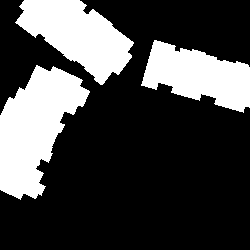

In [ ]:
image